<a href="https://colab.research.google.com/github/MHX1203/DataWhale--/blob/master/DigitsRecognization_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 载入数据

In [0]:
# 连接google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# 解压数据

!mkdir data
!unzip drive/My\ Drive/Data/Datawhale-DigitsRecognition/mchar_test_a.zip -d data/ > /dev/null 2>&1
!unzip drive/My\ Drive/Data/Datawhale-DigitsRecognition/mchar_train.zip -d data/ > /dev/null 2>&1
!unzip drive/My\ Drive/Data/Datawhale-DigitsRecognition/mchar_val.zip -d data/ > /dev/null 2>&1


In [0]:
data_dir = {
    'train_data': '/content/data/mchar_train/',
    'val_data': '/content/data/mchar_val/',
    'test_data': '/content/data/mchar_test_a/',
    'train_label': '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/mchar_train.json',
    'val_label': '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/mchar_val.json',
    'submit_file': '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/mchar_sample_submit_A.csv'
}

# 导入相关库

In [0]:
import os
from glob import glob
import torch as t
t.random.manual_seed(0)
t.cuda.manual_seed_all(0)
t.backends.cudnn.benchmark = True
t.backends.cudnn.deterministic = True
from PIL import Image
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, MultiStepLR, CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch 
import torch.nn.functional as F
import json
from torchvision.models.mobilenet import mobilenet_v2
from torchvision.models.resnet import resnet18, resnet34
from torchsummary import summary
%matplotlib inline

# 查看数据

In [0]:
def data_summary():
  train_list = glob(data_dir['train_data']+'*.png')
  test_list = glob(data_dir['test_data']+'*.png')
  val_list = glob(data_dir['val_data']+'*.png')
  print('train image counts: %d'%len(train_list))
  print('val image counts: %d'%len(val_list))
  print('test image counts: %d'%len(test_list))

data_summary()

train image counts: 30000
val image counts: 10000
test image counts: 40000


In [0]:
def look_train_json():
  with open(data_dir['train_label'], 'r', encoding='utf-8') as f:
    content = f.read()

  content = json.loads(content)

  print(content['000000.png'])

look_train_json()

{'height': [219, 219], 'label': [1, 9], 'left': [246, 323], 'top': [77, 81], 'width': [81, 96]}


In [0]:
def look_submit():
  df = pd.read_csv(data_dir['submit_file'], sep=',')
  print(df.head(5))

look_submit()

    file_name  file_code
0  000000.png          0
1  000001.png          0
2  000002.png          0
3  000003.png          0
4  000004.png          0


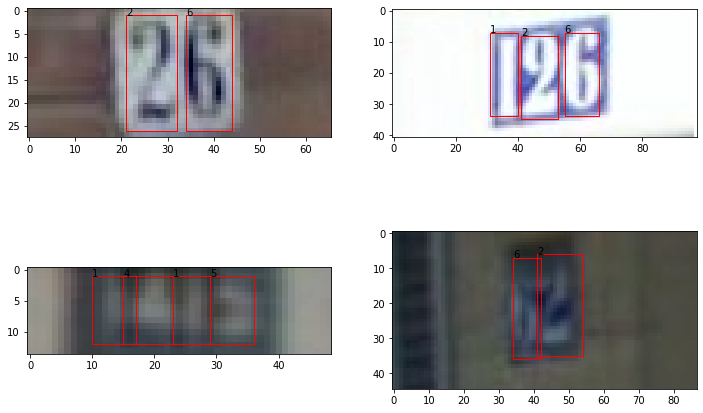

In [0]:
def plot_samples():
  imgs = glob(data_dir['train_data']+'*.png')
  fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)
  marks = json.loads(open(data_dir['train_label'], 'r').read())


  for i in range(4):
    
    img_name = os.path.split(imgs[i])[-1]
    mark = marks[img_name]


    img = Image.open(imgs[i])
    img = np.array(img)

    bboxes = np.array(
        [mark['left'],
        mark['top'],
        mark['width'],
        mark['height']]
    )
    ax[i//2, i%2].imshow(img)
    for j in range(len(mark['label'])):
      rect = patch.Rectangle(bboxes[:, j][:2], bboxes[:, j][2], bboxes[:, j][3], facecolor='none', edgecolor='r')
      ax[i//2, i%2].text(bboxes[:, j][0], bboxes[:, j][1], mark['label'][j])
      ax[i//2, i%2].add_patch(rect)
  plt.show()

plot_samples()

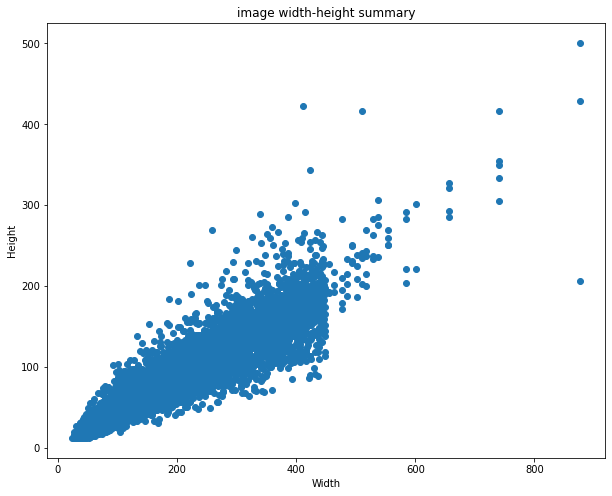

mean:  [128.27233333  57.23066667]
median:  [104.  47.]


In [0]:
def img_size_summary():
  sizes = []

  for img in glob(data_dir['train_data']+'*.png'):
    img = Image.open(img)

    sizes.append(img.size)

  sizes = np.array(sizes)

  plt.figure(figsize=(10, 8))
  plt.scatter(sizes[:, 0], sizes[:, 1])
  plt.xlabel('Width')
  plt.ylabel('Height')

  plt.title('image width-height summary')
  plt.show()

  return np.mean(sizes, axis=0), np.median(sizes, axis=0)

mean, median = img_size_summary()
print('mean: ', mean)
print('median: ', median)

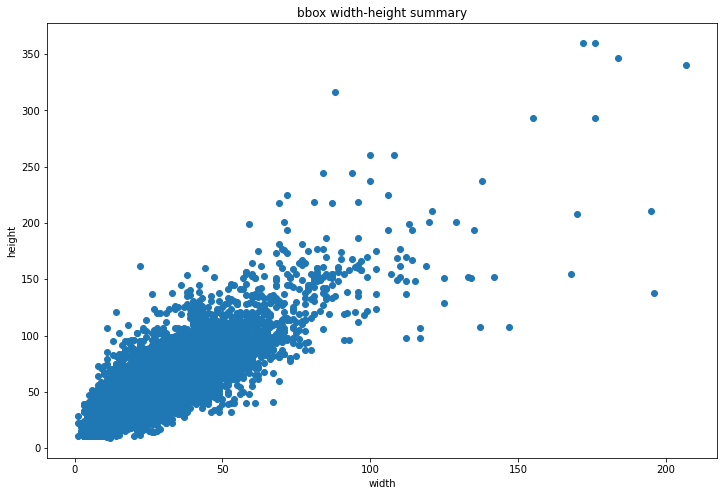

mean: 30.20, median: 22.00


In [0]:
def bbox_summary():
  marks = json.loads(open(data_dir['train_label'], 'r').read())
  bboxes = []

  for img, mark in marks.items():
    for i in range(len(mark['label'])):
      bboxes.append([mark['left'][i], mark['top'][i], mark['width'][i], mark['height'][i]])

  bboxes = np.array(bboxes)

  fig, ax = plt.subplots(figsize=(12, 8))
  ax.scatter(bboxes[:, 2], bboxes[:, 3])
  ax.set_title('bbox width-height summary')
  ax.set_xlabel('width')
  ax.set_ylabel('height')
  plt.show()
  return np.mean(bboxes), np.median(bboxes)

mean, median = bbox_summary()
print('mean: %.2f, median: %.2f'%(mean, median))

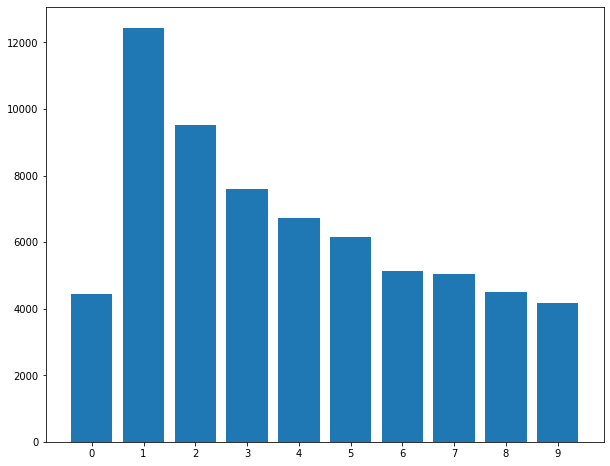

{0: 4444, 1: 12446, 2: 9532, 3: 7608, 4: 6720, 5: 6146, 6: 5141, 7: 5032, 8: 4510, 9: 4186}


In [0]:
def label__nums_summary():
  marks = json.load(open(data_dir['train_label'], 'r'))
  
  dicts = {i: 0 for i in range(10)}
  for img, mark in marks.items():
    for lb in mark['label']:
      dicts[lb] += 1

  xticks = list(range(10))
  # df = pd.DataFrame(dicts, columns=['label', 'nums'])
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.bar(x=list(dicts.keys()), height=list(dicts.values()))
  ax.set_xticks(xticks)
  plt.show()
  return dicts

print(label__nums_summary())

In [0]:
def label_summary():
  marks = json.load(open(data_dir['train_label'], 'r'))
  
  dicts = {}
  for img, mark in marks.items():
    if len(mark['label']) not in dicts:
      dicts[len(mark['label'])] = 0
    dicts[len(mark['label'])] += 1


  dicts = sorted(dicts.items(), key=lambda x: x[0])
  for k, v in dicts:
    print('%d个数字的图片数目: %d'%(k, v))

label_summary()

1个数字的图片数目: 4636
2个数字的图片数目: 16262
3个数字的图片数目: 7813
4个数字的图片数目: 1280
5个数字的图片数目: 8
6个数字的图片数目: 1


In [0]:
def label_summary():
  marks = json.load(open(data_dir['val_label'], 'r'))
  
  dicts = {}
  for img, mark in marks.items():
    if len(mark['label']) not in dicts:
      dicts[len(mark['label'])] = 0
    dicts[len(mark['label'])] += 1


  dicts = sorted(dicts.items(), key=lambda x: x[0])
  for k, v in dicts:
    print('%d个数字的图片数目: %d'%(k, v))

label_summary()

1个数字的图片数目: 1918
2个数字的图片数目: 6393
3个数字的图片数目: 1569
4个数字的图片数目: 118
5个数字的图片数目: 2


# 构建分类Baseline

## 网络配置信息

In [0]:
class Config:

  batch_size = 64

  lr = 1e-2

  momentum = 0.9

  weights_decay = 1e-4

  class_num = 11

  eval_interval = 1

  checkpoint_interval = 1

  print_interval = 50

  checkpoints = 'drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/'

  pretrained = None#'/content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/epoch-resnet18-13-bn-acc-58.34.pth'

  start_epoch = 0

  epoches = 100

  smooth = 0.1

  erase_prob = 0.5

config = Config()



## 构建数据集

In [0]:
class DigitsDataset(Dataset):
    """
    
    DigitsDataset

    Params:
      data_dir(string): data directory

      label_path(string): label path

      aug(bool): wheather do image augmentation, default: True
    """
    def __init__(self, mode='train', size=(128, 256), aug=True):
      super(DigitsDataset, self).__init__()
      
      self.aug = aug
      self.size = size
      self.mode = mode
      self.width = 224
      # self.weights = np.array(list(label__nums_summary().values()))
      # self.weights = (np.sum(self.weights) - self.weights) / self.weights
      # self.weights = t.from_numpy(self.weights.to_list().append(1)).float()
      self.batch_count = 0
      if mode == 'test':
        self.imgs = glob(data_dir['test_data']+'*.png')
        self.labels = None
      else:
        labels = json.load(open(data_dir['%s_label'%mode], 'r'))

        imgs = glob(data_dir['%s_data'%mode]+'*.png')
        self.imgs = [(img, labels[os.path.split(img)[-1]]) for img in imgs \
                if os.path.split(img)[-1] in labels]

    def __getitem__(self, idx):
      if self.mode != 'test':
        img, label = self.imgs[idx]
      else:
        img = self.imgs[idx]
        label = None
      img = Image.open(img)
      trans0 = [                
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ]
      min_size = self.size[0] if (img.size[1] / self.size[0]) < ((img.size[0] / self.size[1])) else self.size[1]
      trans1 = [
            transforms.Resize(128),    
            transforms.CenterCrop((128, self.width))
          ]
      if self.aug:
        trans1.extend([
            transforms.ColorJitter(0.1, 0.1, 0.1),
            transforms.RandomGrayscale(0.1),
            transforms.RandomAffine(15,translate=(0.05, 0.1), shear=5)
        ])
      trans1.extend(trans0)
      if self.mode != 'test':
        return transforms.Compose(trans1)(img), t.tensor(label['label'][:4] + (4 - len(label['label']))*[10]).long()
      else:
        # trans1.append(transforms.RandomErasing(scale=(0.02, 0.1)))
        return transforms.Compose(trans1)(img), self.imgs[idx]


    def __len__(self):
      return len(self.imgs)

    def collect_fn(self, batch):
      imgs, labels = zip(*batch)
      if self.mode == 'train':
        if self.batch_count > 0 and self.batch_count % 10 == 0:
          self.width = random.choice(range(224, 256, 16))

      self.batch_count += 1
      return t.stack(imgs).float(), t.stack(labels)



In [0]:
# test dataset
dataset = DigitsDataset(mode='train')
loader = DataLoader(dataset, batch_size=4, collate_fn=dataset.collect_fn)
img, label = iter(loader).next()
# print(len(dataset))
# img, label = dataset[0]

print(img.shape, label)

torch.Size([4, 3, 128, 224]) tensor([[ 2,  6, 10, 10],
        [ 1,  2,  6, 10],
        [ 1,  4,  1,  5],
        [ 6,  2, 10, 10]])


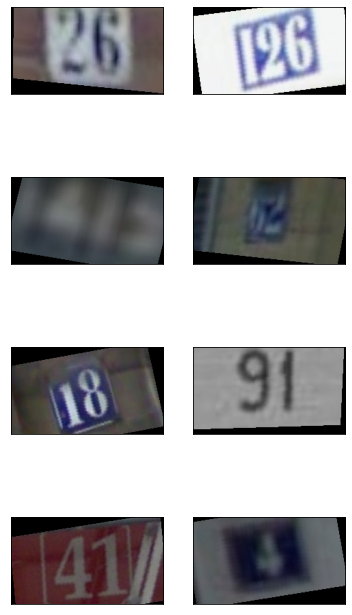

In [0]:
fig, ax = plt.subplots(figsize=(6, 12), nrows=4, ncols=2)
for i in range(8):
  img, label = dataset[i]
  img = img * t.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + t.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
  ax[i//2, i%2].imshow(img.permute(1, 2, 0).numpy())

  ax[i//2, i%2].set_xticks([])
  ax[i//2, i%2].set_yticks([])

plt.show()


## 构建分类模型

In [0]:
class DigitsMobilenet(nn.Module):

  def __init__(self, class_num=11):
    super(DigitsMobilenet, self).__init__()

    self.net = mobilenet_v2(pretrained=True).features
    # self.net.classifier = nn.Identity()
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.bn = nn.BatchNorm1d(1280)
    self.fc1 = nn.Linear(1280, class_num)
    self.fc2 = nn.Linear(1280, class_num)
    self.fc3 = nn.Linear(1280, class_num)
    self.fc4 = nn.Linear(1280, class_num)
    # self.fc5 = nn.Linear(1280, class_num)

  def forward(self, img):
    features = self.avgpool(self.net(img)).view(-1, 1280)
    features = self.bn(features)

    fc1 = self.fc1(features)
    fc2 = self.fc2(features)
    fc3 = self.fc3(features)
    fc4 = self.fc4(features)
    # fc5 = self.fc5(features)

    return fc1, fc2, fc3, fc4


class DigitsResnet18(nn.Module):

  def __init__(self, class_num=11):
    super(DigitsResnet18, self).__init__()
    self.net = resnet18(pretrained=True)
    self.net.fc = nn.Identity()
    # self.net = nn.Sequential(
    #     MobileNetV2(num_classes=class_num).features,
    #     nn.AdaptiveAvgPool2d((1, 1))
    # )
    self.bn = nn.BatchNorm1d(512)
    self.fc1 = nn.Linear(512, class_num)
    self.fc2 = nn.Linear(512, class_num)
    self.fc3 = nn.Linear(512, class_num)
    self.fc4 = nn.Linear(512, class_num)
    # self.fc5 = nn.Linear(512, class_num)

  def forward(self, img):
    features = self.net(img).squeeze()

    fc1 = self.fc1(features)
    fc2 = self.fc2(features)
    fc3 = self.fc3(features)
    fc4 = self.fc4(features)
    # fc5 = self.fc5(features)

    return fc1, fc2, fc3, fc4

In [0]:
# 查看网络结构
net = resnet18(pretrained=True)
net.to(t.device('cuda'))
summary(net, input_size=(3, 64, 128), batch_size=config.batch_size)

In [0]:
net = DigitsMobilenet()
print(net)

In [0]:
# 查看网络结构
net.to(t.device('cuda'))
summary(net, input_size=(3, 64, 128), batch_size=config.batch_size)


## 训练模型

In [0]:
# ----------------------------------- LabelSmoothEntropy ----------------------------------- #
class LabelSmoothEntropy(nn.Module):
  def __init__(self, smooth=0.1, class_weights=None, size_average='mean'):
    super(LabelSmoothEntropy, self).__init__()
    self.size_average = size_average
    self.smooth = smooth

    self.class_weights = class_weights
    

  def forward(self, preds, targets):

    lb_pos, lb_neg = 1 - self.smooth, self.smooth / (preds.shape[0] - 1)

    smoothed_lb = t.zeros_like(preds).fill_(lb_neg).scatter_(1, targets[:, None], lb_pos)

    log_soft = F.log_softmax(preds, dim=1)

    if self.class_weights is not None:
      loss = -log_soft * smoothed_lb * self.class_weights[None, :]

    else:
      loss = -log_soft * smoothed_lb

    loss = loss.sum(1)
    if self.size_average == 'mean':
      return loss.mean()

    elif self.size_average == 'sum':
      return loss.sum()
    else:
      raise NotImplementedError

  

In [0]:
# ----------------------------------- SnapShot ----------------------------------- #
class SnapShotBuilder():

  """
  
  Params:
    n_epoch(integer): total training epoches

    n_snap(integer): parameters of model saved times

  """
  def __init__(self, n_epoch, n_snap):

    self.n_epoch = n_epoch

    self.n_snap = n_snap

    pass

  def __call__(self):

    pass

  def _scheduler(self):

    pass

In [0]:
class Trainer:

  def __init__(self, val=True):

    self.device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')

    self.train_set = DigitsDataset(mode='train')
    self.train_loader = DataLoader(self.train_set, batch_size=config.batch_size, shuffle=True, num_workers=8, pin_memory=True, \
                    drop_last=True, collate_fn=self.train_set.collect_fn)
    
    if val:
      self.val_loader = DataLoader(DigitsDataset(mode='val', aug=False), batch_size=config.batch_size,\
                    num_workers=8, pin_memory=True, drop_last=False)
    else:
      self.val_loader = None

    self.model = DigitsMobilenet(config.class_num).to(self.device)
    # self.model = DigitsResnet18(config.class_num).to(self.device)


    self.criterion = LabelSmoothEntropy().to(self.device)

    # self.optimizer = SGD(self.model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weights_decay, nesterov=True)
    from torch.optim import Adam
    self.optimizer = Adam(self.model.parameters(), lr=1e-2)
    self.lr_scheduler = CosineAnnealingWarmRestarts(self.optimizer, 10, 2, eta_min=10e-4)
    # self.lr_scheduler = (self.optimizer, [10, 20, 30], 0.5)
    self.best_acc = 0

    if config.pretrained is not None:
      self.load_model(config.pretrained)
      # print('Load model from %s'%config.pretrained)
      if self.val_loader is not None:
        acc = self.eval()
      self.best_acc = acc
      print('Load model from %s, Eval Acc: %.2f'%(config.pretrained, acc * 100))



  def train(self):
    for epoch in range(config.start_epoch, config.epoches):
      acc = self.train_epoch(epoch)
      if (epoch + 1) % config.eval_interval == 0:
        print('Start Evaluation')
        if self.val_loader is not None:
          acc = self.eval() 

        if acc > self.best_acc:
          os.makedirs(config.checkpoints, exist_ok=True)
          save_path = config.checkpoints+'epoch-resnet18-%d-bn-acc-%.2f.pth'%(epoch+1, acc*100)
          self.save_model(save_path)
          print('%s saved successfully...'%save_path)
          self.best_acc = acc

  def train_epoch(self, epoch):
    total_loss = 0
    corrects = 0
    tbar = tqdm(self.train_loader)
    self.model.train()
    for i, (img, label) in enumerate(tbar):
      # print(img.shape)
      img = img.to(self.device)
      label = label.to(self.device)
      self.optimizer.zero_grad()
      pred = self.model(img)
      loss = self.criterion(pred[0], label[:, 0]) + \
          self.criterion(pred[1], label[:, 1]) + \
          self.criterion(pred[2], label[:, 2]) + \
          self.criterion(pred[3], label[:, 3]) \
          #+ self.criterion(pred[4], label[:, 4])
      total_loss += loss.item()
      loss.backward() 
      self.optimizer.step()
      temp = t.stack([\
            pred[0].argmax(1) == label[:, 0],\
            pred[1].argmax(1) == label[:, 1],\
            pred[2].argmax(1) == label[:, 2],\
            pred[3].argmax(1) == label[:, 3],], dim=1)

      corrects += t.all(temp, dim=1).sum().item()
      tbar.set_description('loss: %.3f, acc: %.3f'%(loss/(i+1), corrects*100/((i + 1) * config.batch_size)))
      if (i + 1) % config.print_interval == 0:
        self.lr_scheduler.step()
        
    return corrects*100/((i + 1) * config.batch_size)

  def eval(self):
    self.model.eval()
    corrects = 0
    with t.no_grad():
      tbar = tqdm(self.val_loader)
      for i, (img, label) in enumerate(tbar):
        img = img.to(self.device)
        label = label.to(self.device)
        pred = self.model(img)
        # temp = t.stack([])
        temp = t.stack([
			      pred[0].argmax(1) == label[:, 0], \
            pred[1].argmax(1) == label[:, 1], \
            pred[2].argmax(1) == label[:, 2], \
            pred[3].argmax(1) == label[:, 3], \
        ], dim=1)

        corrects += t.all(temp, dim=1).sum().item()
        tbar.set_description('Val Acc: %.2f'%(corrects * 100 /((i+1)*config.batch_size)))
    self.model.train()
    return corrects / (len(self.val_loader) * config.batch_size)

  def save_model(self, save_path, save_opt=False, save_config=False):
    dicts = {}
    dicts['model'] = self.model.state_dict()
    if save_opt:
      dicts['opt'] = self.optimizer.state_dict()

    if save_config:
      dicts['config'] = {s: config.__getattribute__(s) for s in dir(config) if not s.startswith('_')}

    t.save(dicts, save_path)

  def load_model(self, load_path, changed=False, save_opt=False, save_config=False):

    dicts = t.load(load_path)
    if not changed:
      self.model.load_state_dict(dicts['model'])

    else:
      dicts = t.load(load_path)['model']

      keys = list(net.state_dict().keys())
      values = list(dicts.values())

      new_dicts = {k: v for k, v in zip(keys, values)}
      self.model.load_state_dict(new_dicts)

    if save_opt:
      self.optimizer.load_state_dict(dicts['opt'])

    if save_config:
      for k, v in dicts['config'].items():
        config.__setattr__(k, v)


In [0]:
trainer = Trainer()
trainer.train()

## 多模型堆叠验证

In [0]:
def stack_eval(mb_path, res_path):
  mb_net = DigitsMobilenet().cuda()
  dicts = t.load(mb_path)['model']
  # dicts.popitem()
  # dicts.popitem()
  mb_net.load_state_dict(dicts)


  res_net = DigitsResnet18().cuda()
  res_net.load_state_dict(t.load(res_path)['model'])
  
  res_net.eval()
  mb_net.eval()
  dataset = DigitsDataset(mode='val', aug=False)
  imgs = glob(data_dir['val_data']+'*.png')
  labels = json.load(open(data_dir['val_label'], 'r'))
  dataset.imgs = [(img, labels[os.path.split(img)[-1]]) for img in imgs if os.path.split(img)[-1] in labels]
  val_loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False,\
                    num_workers=16, pin_memory=True, drop_last=False)
  corrects = 0
  with t.no_grad():
    tbar = tqdm(val_loader)
    for i, (img, label) in enumerate(tbar):
      img = img.cuda()
      label = t.tensor(label).long().cuda()
      pred = [0.4 * a + 0.6 * b for a, b in zip(res_net(img), mb_net(img))]


      # temp = t.stack([])
      temp = t.stack([
		      pred[0].argmax(1) == label[:, 0], \
          pred[1].argmax(1) == label[:, 1], \
          pred[2].argmax(1) == label[:, 2], \
          pred[3].argmax(1) == label[:, 3], \
      ], dim=1)
      corrects += t.all(temp, dim=1).sum().item()
      tbar.set_description('Val Acc: %.2f'%(corrects * 100 /((i+1)*config.batch_size)))
  self.model.train()
  return corrects / (len(val_loader) * config.batch_size)
  
def stack_predict(*model, batch_size=64):
  val_loader = DataLoader(DigitsDataset(mode='test', aug=False), batch_size=batch_size, shuffle=False,\
                      num_workers=8, pin_memory=True, drop_last=False)
  
  
  results = []
  corrects = 0
  total = 0
  for m in model:
    m.eval()
    m.cuda()
  tbar = tqdm(val_loader)
  with t.no_grad():
    for i, (img, label) in enumerate(tbar):
      img = img.cuda()
      # label = label.cuda()
      # ---------取平均值----------#
      # ------------74.51---------------#
      pred = [0]*4
      for a in [m(img) for m in model]:

        pred = [p + a_ for p, a_ in zip(pred, a)]
      pred = [p / len(model) for p in pred]
      results += [[name, code] for name, code in zip(label, parse2class(pred))]

  results = sorted(results, key=lambda x: x[0])

  write2csv(results)

model_paths = glob('/content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/*.pth')
models = []
for m in model_paths:
  if 'resnet' in m:
    model = DigitsResnet18()
  elif 'mobilenet' in m:
    model = DigitsMobilenet()
  model.load_state_dict(t.load(m)['model'])
  models.append(model)
        
stack_predict(*models, batch_size=256)
# mb_path = '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/epoch-50-mobilenet-bn-acc-0.9284.pth'
# res_path = '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/epoch-34-bn-_acc-71.30.pth'
# print(stack_eval(mb_path, res_path))


Results.saved to /content/drive/My Drive/Data/Datawhale-DigitsRecognition/results-mb.csv


## 预测并生成结果文件

In [0]:
def predicts(model_path):
  test_loader = DataLoader(DigitsDataset(mode='test', aug=False), batch_size=config.batch_size, shuffle=False,\
                    num_workers=8, pin_memory=True, drop_last=False)
  results = []
  
  mb_path = '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/epoch-50-mobilenet-bn-acc-0.9284.pth'
  # res_path = '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/epoch-34-resnet18-bn-acc-71.30.pth'
  mb_net = DigitsMobilenet().cuda()
  # dicts = t.load(mb_path)['model']
  # dicts.popitem()
  # dicts.popitem()
  mb_net.load_state_dict(t.load(mb_path)['model'])


  res_net = DigitsResnet18().cuda()
  res_net.load_state_dict(t.load(res_path)['model'])
  # print('Load model from %s successfully'%model_path)

  tbar = tqdm(test_loader)
  mb_net.eval()
  res_net.eval()
  with t.no_grad():
    for i, (img, img_names) in enumerate(tbar):
      img = img.cuda()
      pred = mb_net(img)
      # pred = [0.4 * a + 0.6 * b for a, b in zip(res_net(img), mb_net(img))]
      results += [[name, code] for name, code in zip(img_names, parse2class(pred))]

  # result.sort(key=results)
  results = sorted(results, key=lambda x: x[0])

  write2csv(results)
  return results



def parse2class(prediction):
  """
  
  Params:
    prediction(tuple of tensor): 

  
  """
  ch1, ch2, ch3, ch4 = prediction

  char_list = [str(i) for i in range(10)]
  char_list.append('')


  ch1, ch2, ch3, ch4 = ch1.argmax(1), ch2.argmax(1), ch3.argmax(1), ch4.argmax(1)

  ch1, ch2, ch3, ch4 = [char_list[i.item()] for i in ch1], [char_list[i.item()] for i in ch2], \
                  [char_list[i.item()] for i in ch3], [char_list[i.item()] for i in ch4] \
                  # ，[char_list[i.item()] for i in ch5]

  # res = [c1+c2+c3+c4+c5 for c1, c2, c3, c4, c5 in zip(ch1, ch2, ch3, ch4, ch5)]  
  res = [c1+c2+c3+c4 for c1, c2, c3, c4 in zip(ch1, ch2, ch3, ch4)]             
  return res


def write2csv(results):
  """
  
  results(list):

  """

  df = pd.DataFrame(results, columns=['file_name', 'file_code'])
  df['file_name'] = df['file_name'].apply(lambda x: x.split('/')[-1])
  save_name = '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/results-mb.csv'
  df.to_csv(save_name, sep=',', index=None)
  print('Results.saved to %s'%save_name)

In [0]:
model_path = '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/'

model_path = sorted(glob(model_path+'*.pth'), key=lambda x: float(x[-9:-4]))[-1]

predicts(model_path)





Results.saved to /content/drive/My Drive/Data/Datawhale-DigitsRecognition/results-mb.csv


[['/content/data/mchar_test_a/000000.png', '59'],
 ['/content/data/mchar_test_a/000001.png', '290'],
 ['/content/data/mchar_test_a/000002.png', '16'],
 ['/content/data/mchar_test_a/000003.png', '39'],
 ['/content/data/mchar_test_a/000004.png', '95'],
 ['/content/data/mchar_test_a/000005.png', '23'],
 ['/content/data/mchar_test_a/000006.png', '26'],
 ['/content/data/mchar_test_a/000007.png', '74'],
 ['/content/data/mchar_test_a/000008.png', '8'],
 ['/content/data/mchar_test_a/000009.png', '118'],
 ['/content/data/mchar_test_a/000010.png', '181'],
 ['/content/data/mchar_test_a/000011.png', '60'],
 ['/content/data/mchar_test_a/000012.png', '70'],
 ['/content/data/mchar_test_a/000013.png', '72'],
 ['/content/data/mchar_test_a/000014.png', '836'],
 ['/content/data/mchar_test_a/000015.png', '40'],
 ['/content/data/mchar_test_a/000016.png', '29'],
 ['/content/data/mchar_test_a/000017.png', '90'],
 ['/content/data/mchar_test_a/000018.png', '46'],
 ['/content/data/mchar_test_a/000019.png', '114